In [58]:
import numpy as np
import quflow as qf
import matplotlib.pyplot as plt
%matplotlib notebook
%config Completer.use_jedi = False
plt.rc('figure', figsize=(10,5))
plt.rc('font', size=14)

# Simulation of Euler's equations on the sphere

In vorticity formulation, Euler's equations are
$$\dot\omega = \{\psi,\omega\} $$
where $\omega$ is the vorticity function and $\psi$ is the stream function
(related to $\omega$ via Poisson's equation).
The quantized Euler equations are similar
$$\dot W = [P,W] $$
but here the vorticity function is replaced by the vorticity matrix
$W \in \mathfrak{su}(N)$ and a corresponding stream matrix $P\in\mathfrak{su}(N)$.

## Create initial conditions

In [2]:
N = 128 # Size of matrices

In [3]:
W0 = qf.shr2mat(qf.as_shr(qf.load("W_0.mat")), N=N)
P0 = qf.solve_poisson(W0)
print(W0.shape)

(128, 128)


<IPython.core.display.Javascript object>


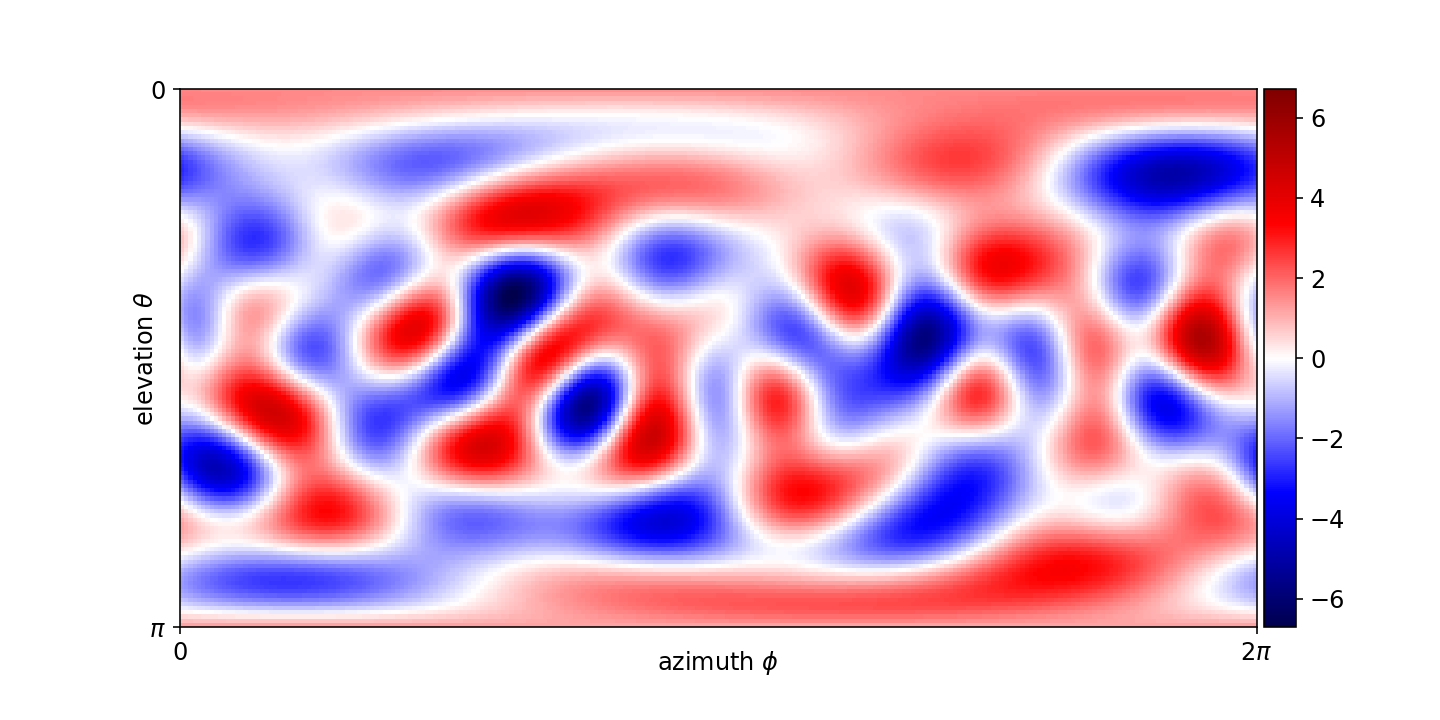

In [54]:
qf.plot(W0)

In [52]:
f.tight_layout?

<IPython.core.display.Javascript object>


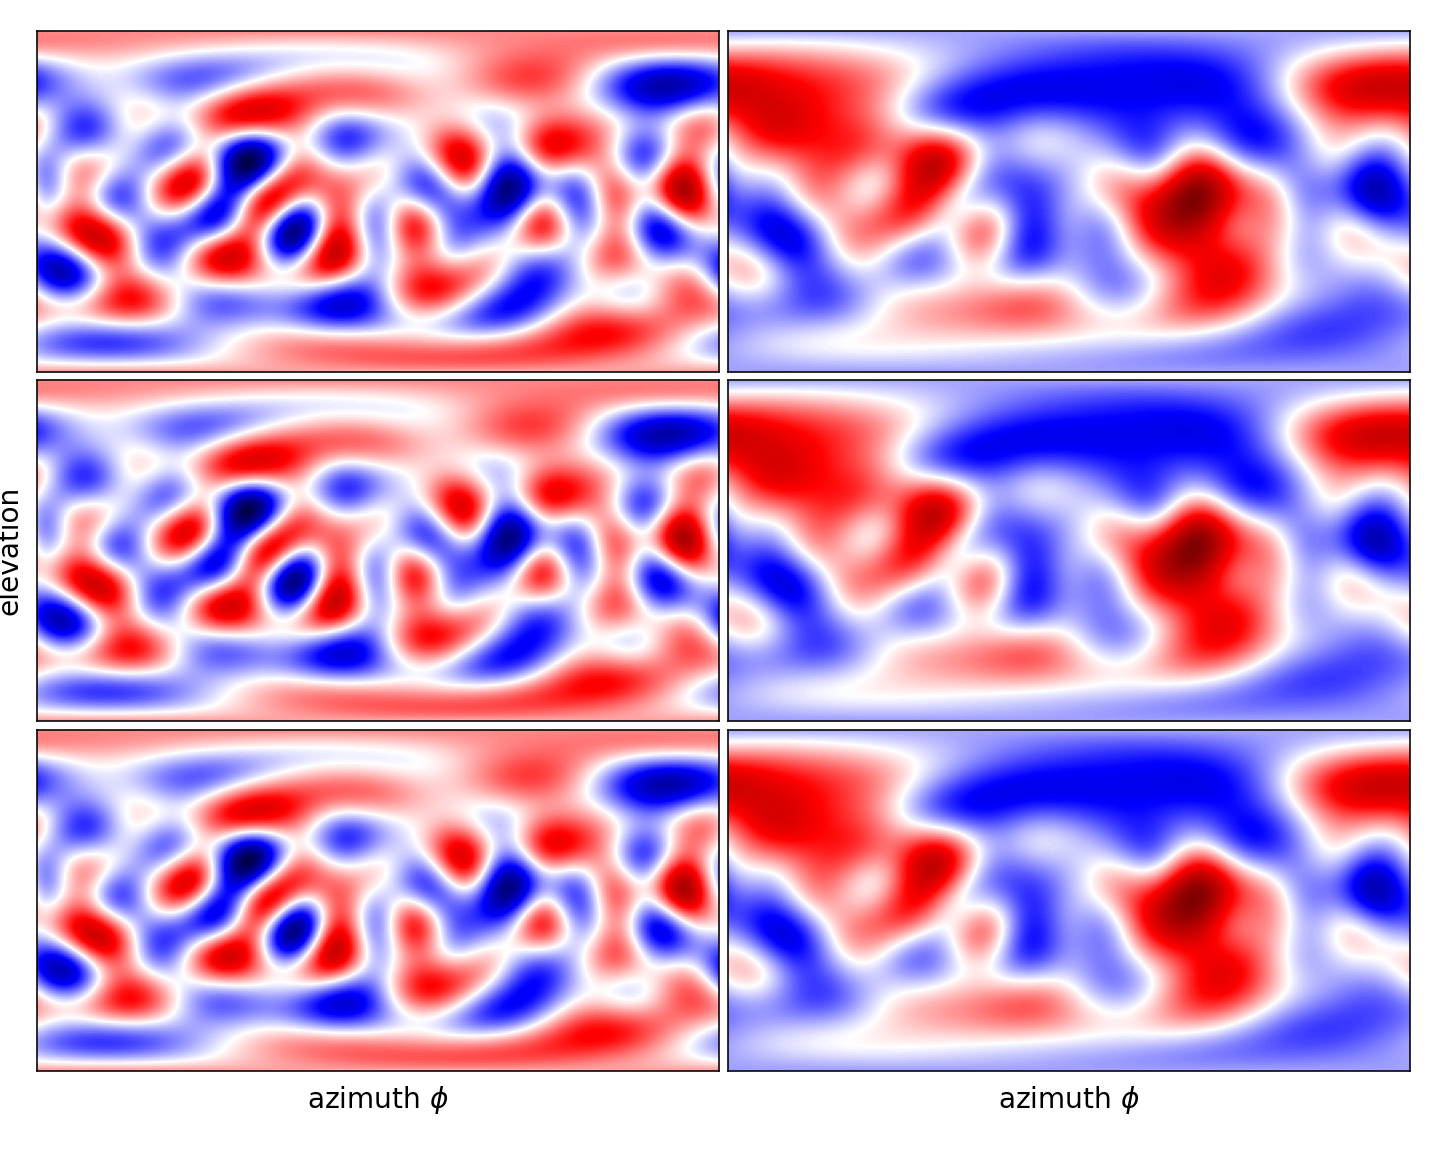

In [62]:
with plt.rc_context({'figure.figsize':(10,7.99)}):
    im = qf.plot([[W0,P0],[W0,P0],[W0,P0]],colorbar=False, use_ticks=False, ylabel=None) # Display initial vorticity using spherical coordinates
    f = im[0,0].axes.figure
    f.tight_layout(h_pad=0.1, w_pad=0.1)
    #ax.axes.set_title('Initial vorticity field in spherical coordinates');
    im[1,0].axes.set_ylabel('elevation')
    #im[0,0].axes.yaxis.set_label_coords(-0.02, 0.5)

In [7]:
im.shape

(2, 2)

In [33]:
%%time
W = W0.copy()
qf.rk4(W, stepsize=0.5, steps=300)
print('Finished!')

Finished!
CPU times: user 4.02 s, sys: 789 ms, total: 4.8 s
Wall time: 966 ms


In [38]:
%%time
W = W0.copy()
qf.isomp(W, stepsize=1.0, steps=300)
print('Finished!')

Finished!
CPU times: user 8.93 s, sys: 840 ms, total: 9.77 s
Wall time: 2.21 s


<IPython.core.display.Javascript object>


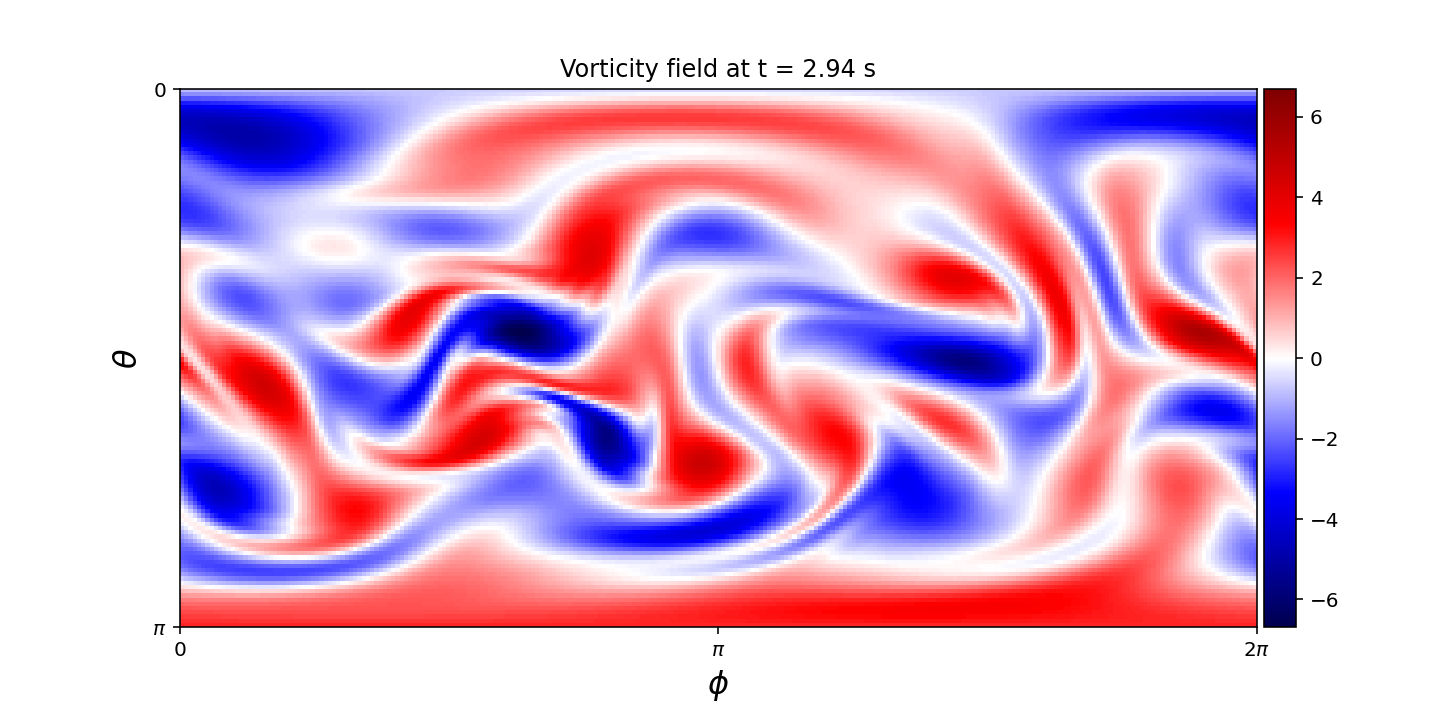

In [39]:
ax = qf.plot(W) # Display initial vorticity using spherical coordinates
ax.axes.set_title("Vorticity field at t = {:.2f} s".format(qf.qtime2seconds(2.0*300, N)));

## Run simulation and animate the results

<IPython.core.display.Javascript object>


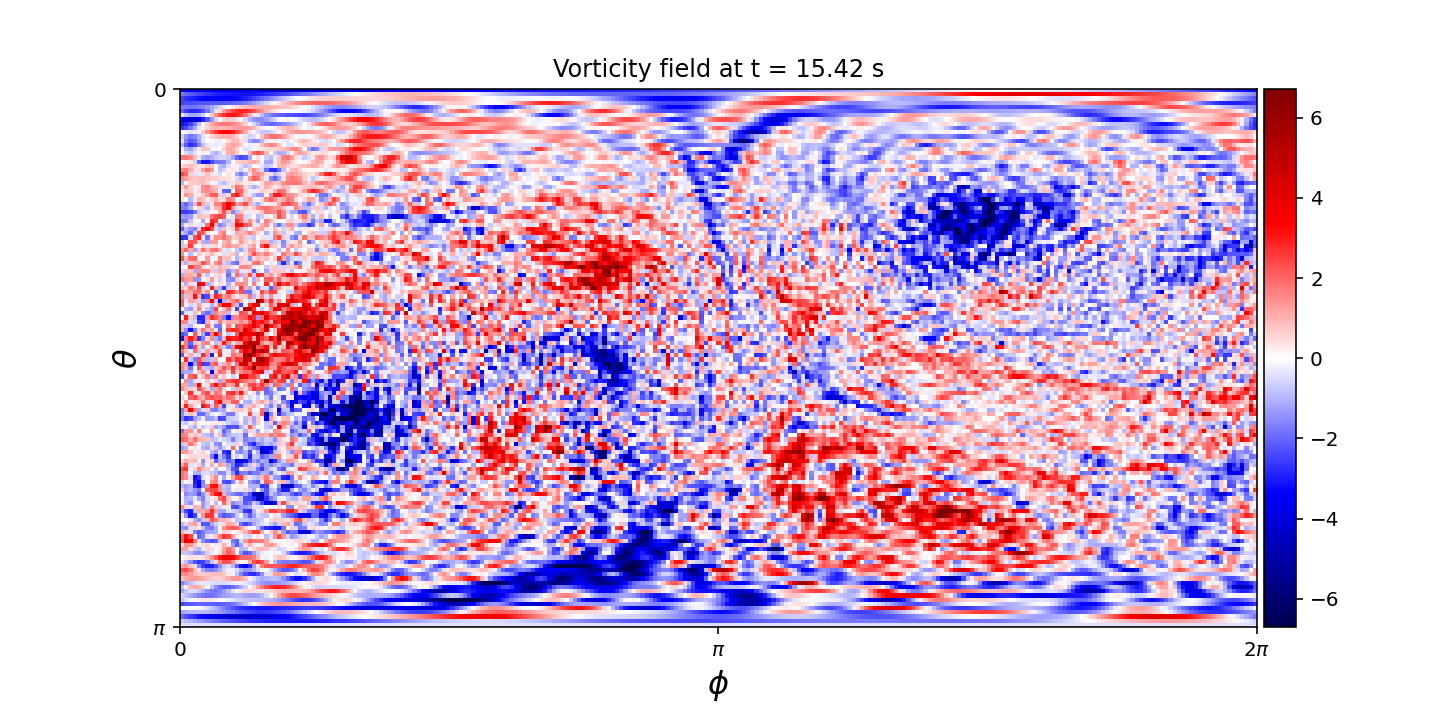

In [41]:
from matplotlib.animation import FuncAnimation

W = W0.copy()
img_ax = qf.plot(W)
h = 3.0 # Stepsize in qtime units
steps_per_frame = 50

def animate(frame_num):
    qf.isomp(W, stepsize=h, steps=steps_per_frame)
    img_ax.set_array(qf.as_fun(W))
    img_ax.axes.set_title("Vorticity field at t = {:.2f} s".format(qf.qtime2seconds(h*steps_per_frame*frame_num, N)))
    return ax

anim = FuncAnimation(img_ax.figure, animate, frames=200, interval=20, repeat=False, blit=True)
plt.show()

## Compute canonical decomposition

In [41]:
[Ws,Wr]=qf.scale_decomposition(W)
P = qf.solve_poisson(W)

In [64]:
np.asarray([Ws, Wr]).shape[-2:]

(128, 128)

In [63]:
np.nditer?

<IPython.core.display.Javascript object>


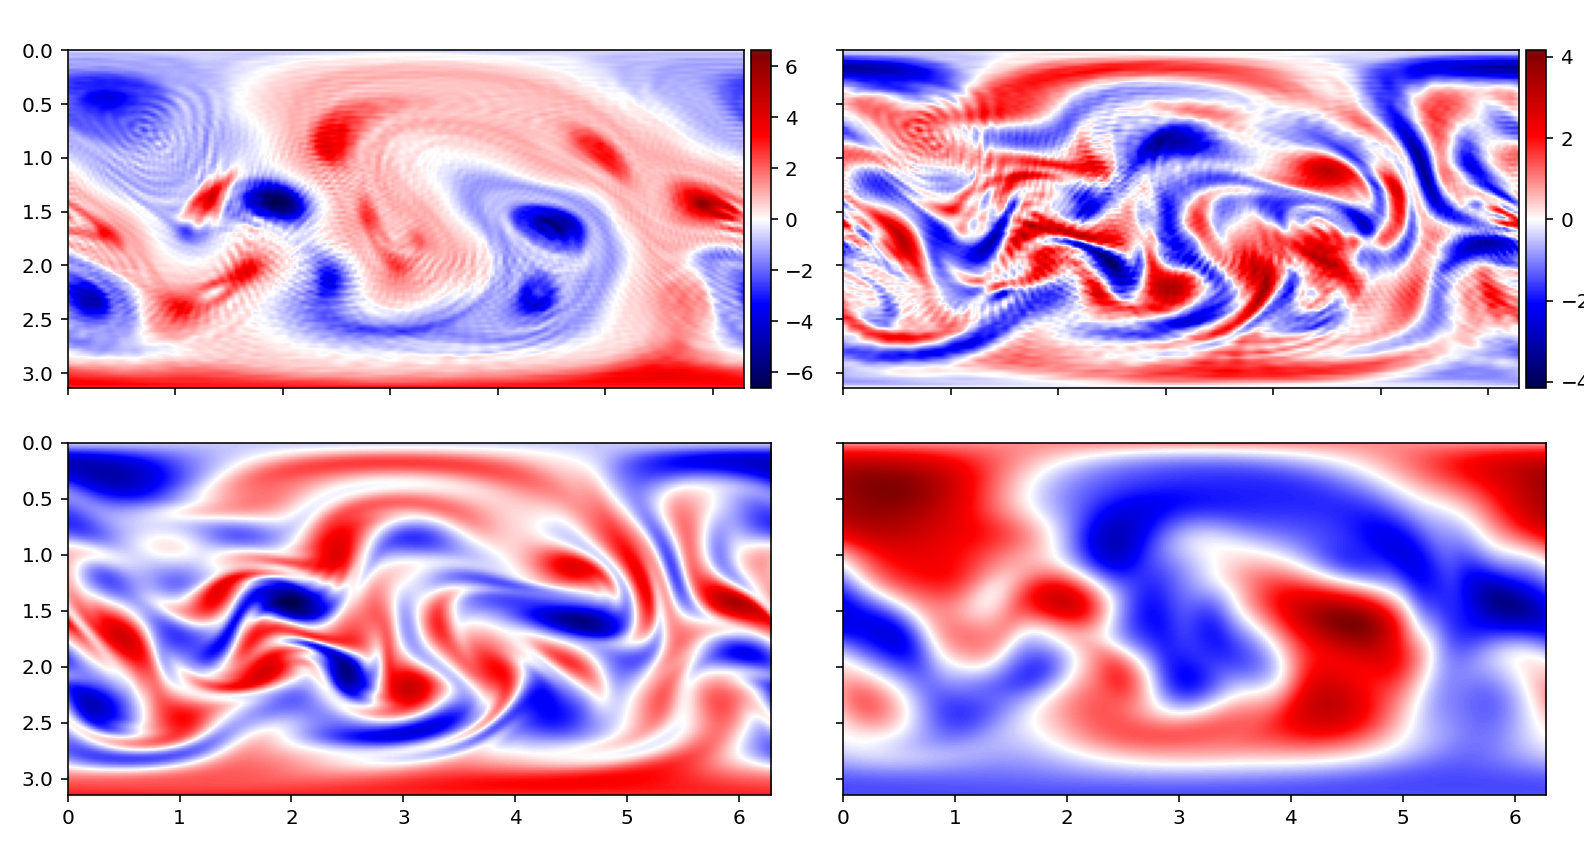

In [62]:
with plt.rc_context({'figure.figsize':(11,6)}):
    fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
    fig.tight_layout(h_pad=0, w_pad=2)
    qf.plot(Ws,axs[0,0], colorbar=True)
    qf.plot(Wr,axs[0,1], colorbar=True)
    qf.plot(W,axs[1,0], colorbar=False)
    qf.plot(P,axs[1,1], colorbar=False)

In [50]:
axs

array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

# Interpretation of eigenvectors

In [120]:
kmax = 40
ee = 1.0j*np.zeros((kmax+1,N,N));
alpha = np.pi-np.arccos(1-np.arange(kmax+1)/N)
for k in range(kmax+1):
    ek = np.zeros(N); ek[k] = 1.0; ee[k,:,:] = 1.0j*(np.outer(ek,ek) - np.eye(N)/N)

In [ ]:
qf.plot(ee[0]+ee[1])

In [102]:
alphak = np.arccos(1-np.arange(6)/N)

In [106]:
np.pi-alphak[1]

3.01651112999681

<IPython.core.display.Javascript object>


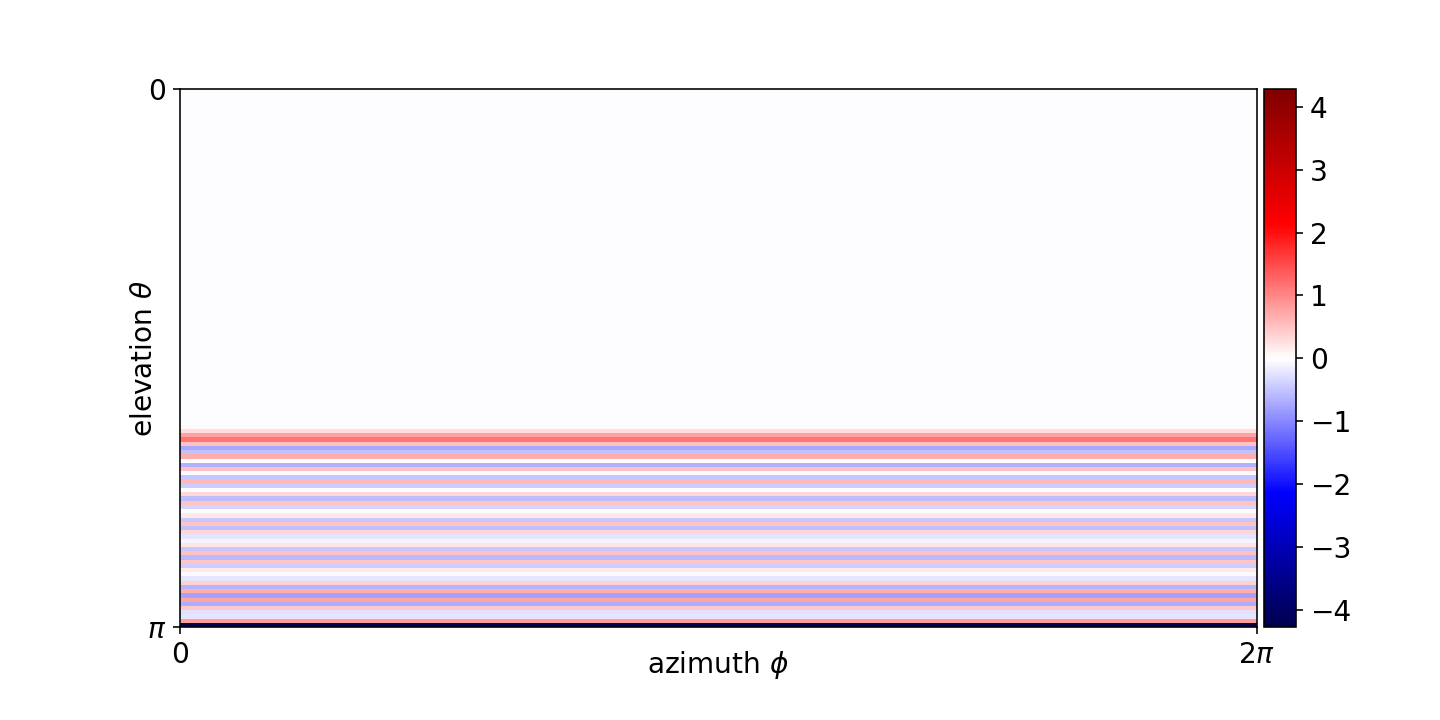

In [130]:
qf.plot(ee[35])

<IPython.core.display.Javascript object>


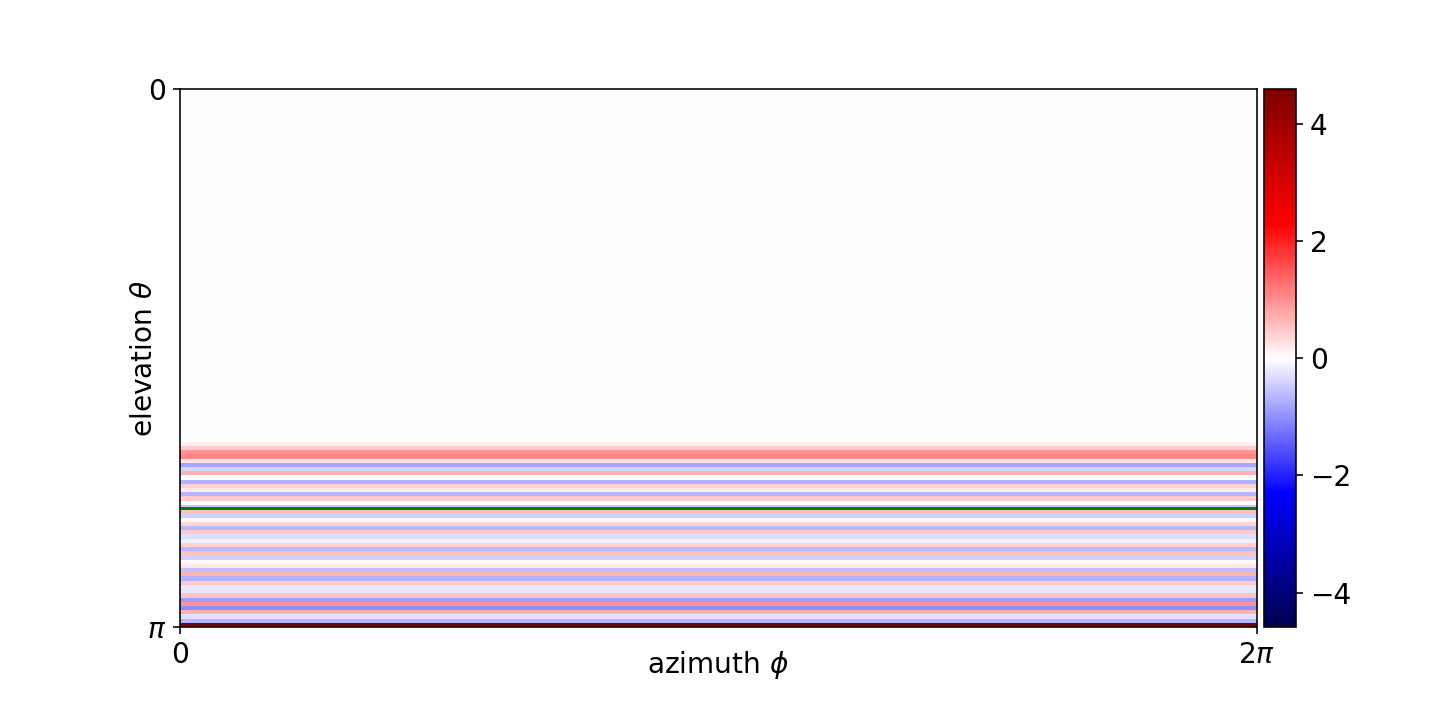

In [125]:
im = qf.plot(ee[30])
azi = np.linspace(0,2*np.pi)
im.axes.plot(azi,alpha[30]*np.ones_like(azi), color='green')


<IPython.core.display.Javascript object>


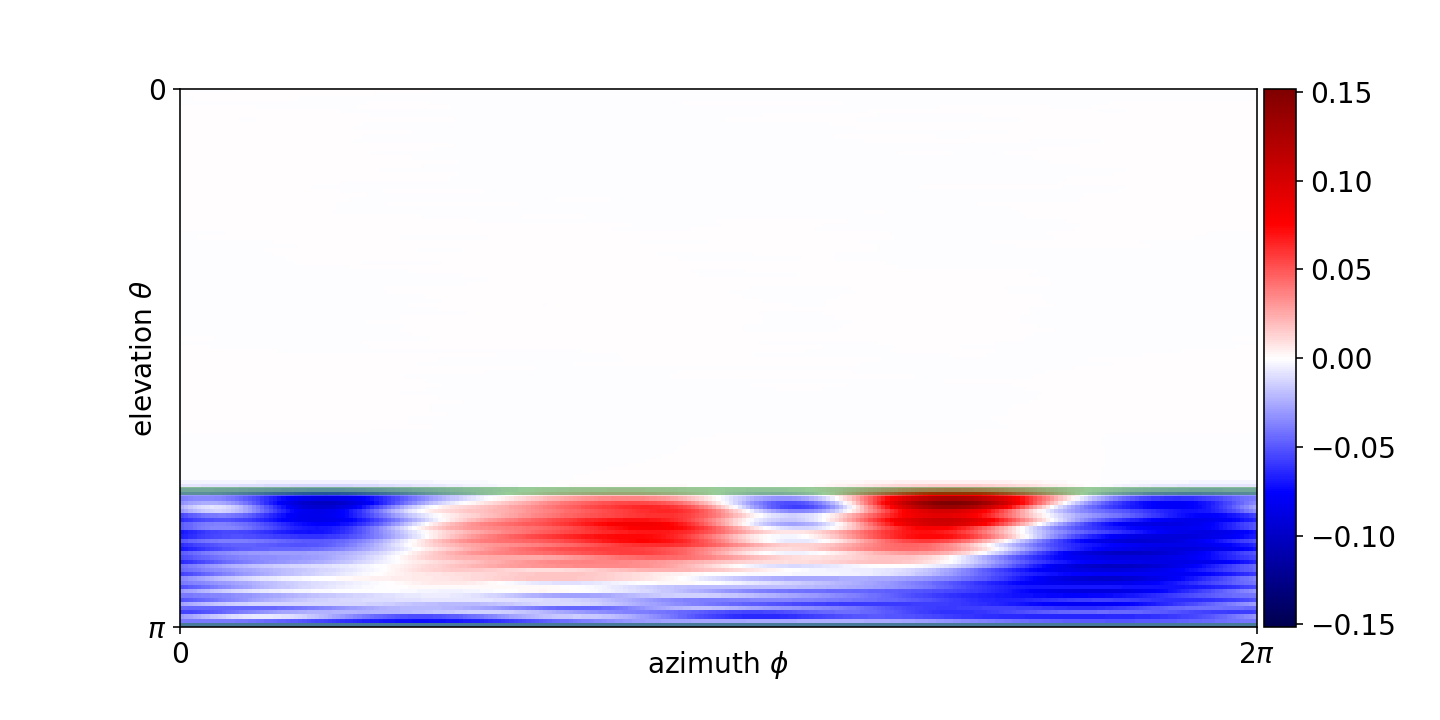

In [207]:
kmin = 0
kmax = 20
Wtest = 1.j*np.zeros((N,N));
Wtest[:kmax,:kmax] = P0[:kmax,:kmax]
Wtest2 = np.zeros_like(W0)
Wtest2[:kmin,:kmin] = P0[:kmin,:kmin]
alpha = np.arccos(np.linspace(-1,1,N, endpoint=True))
im = qf.plot(Wtest-Wtest2)
im.axes.plot(azi,alpha[kmax-1]*np.ones_like(azi), color='green', linewidth=4, alpha=0.4)
im.axes.plot(azi,alpha[kmin]*np.ones_like(azi), color='green', linewidth=4, alpha=0.4)

<IPython.core.display.Javascript object>


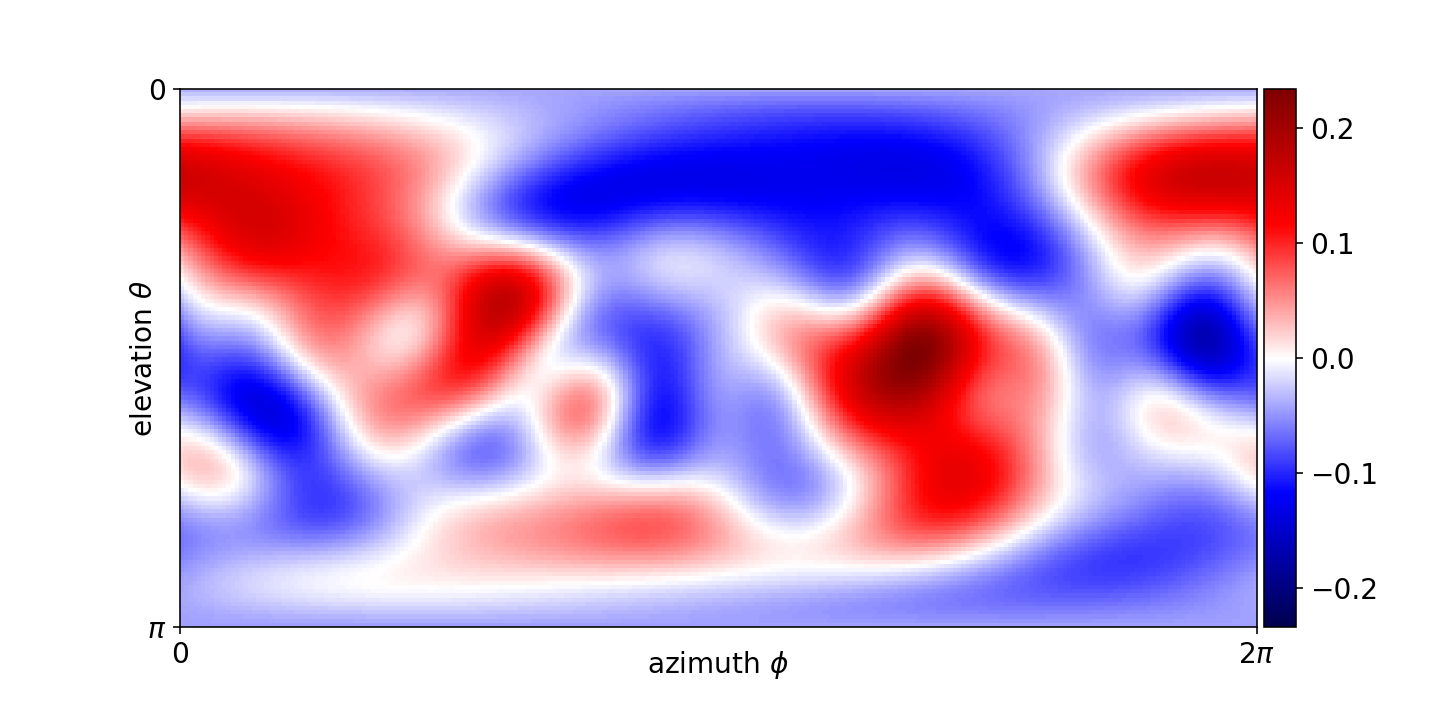

In [206]:
im = qf.plot(P0)

In [212]:
P0[:2,:2]

array([[-0.        -0.01215967j, -0.00484771-0.00123893j],
       [ 0.00484771-0.00123893j, -0.        -0.00963222j]])

<IPython.core.display.Javascript object>


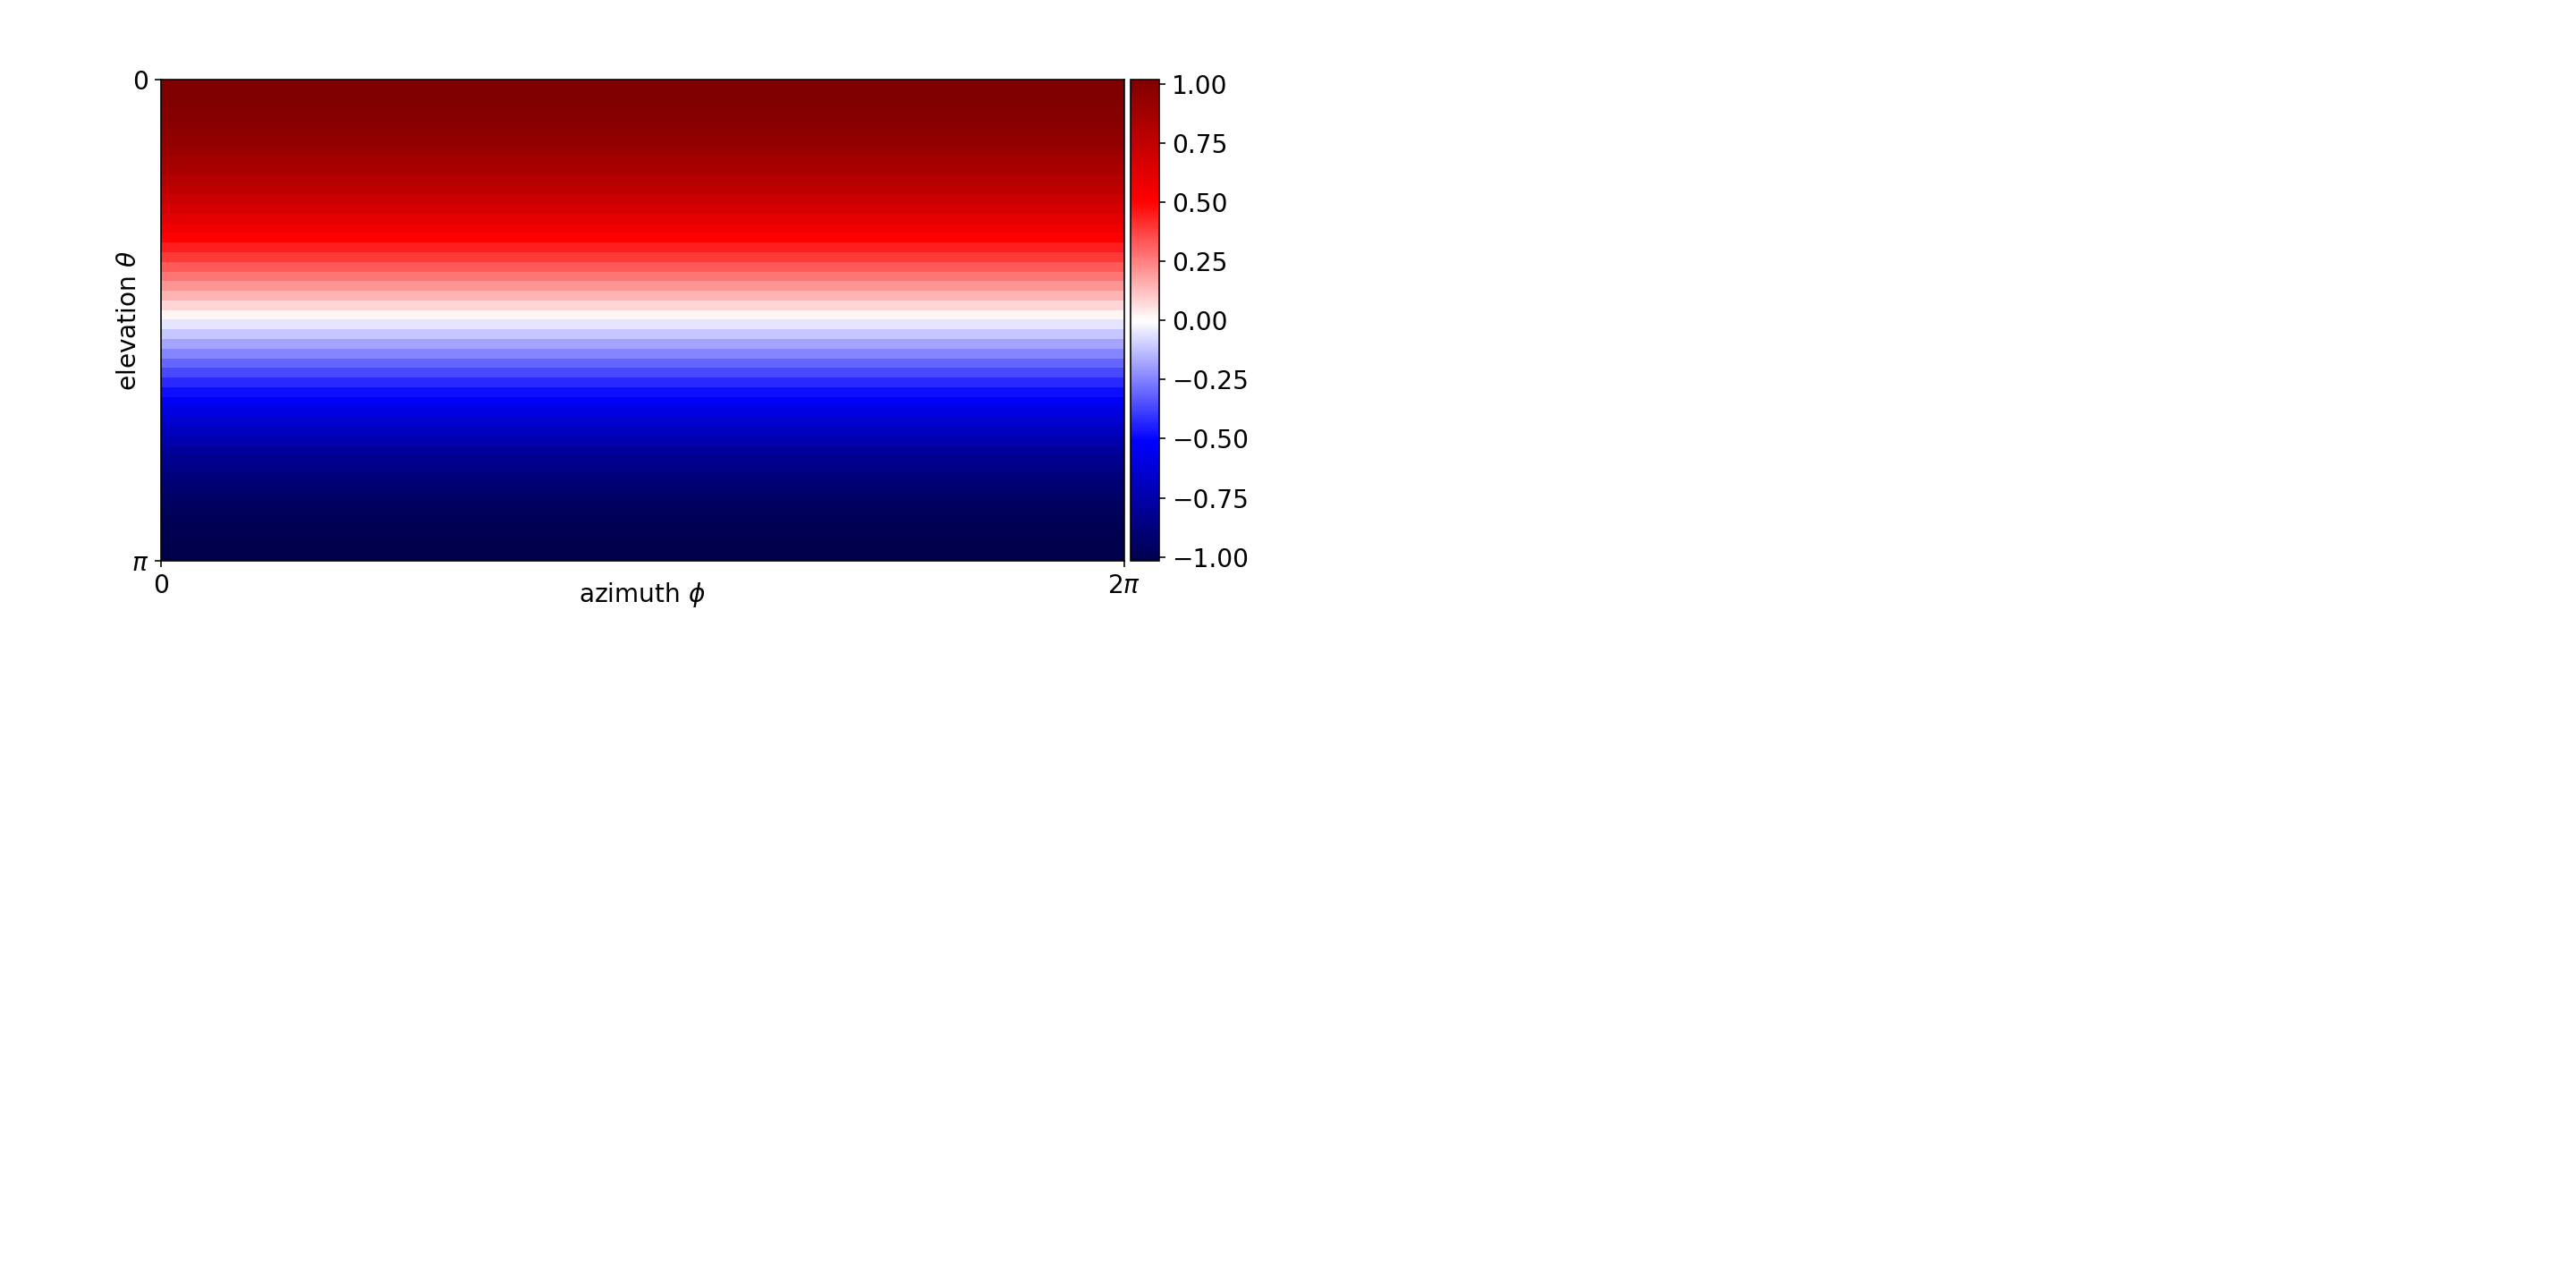

In [169]:
im = qf.plot(1.j*np.diag(np.linspace(-1,1)/2))

In [171]:
lam, E = np.linalg.eig(W0)

In [181]:
np.unravel_index(np.argmax(np.abs(E)),(N,N))

(2, 70)

<IPython.core.display.Javascript object>


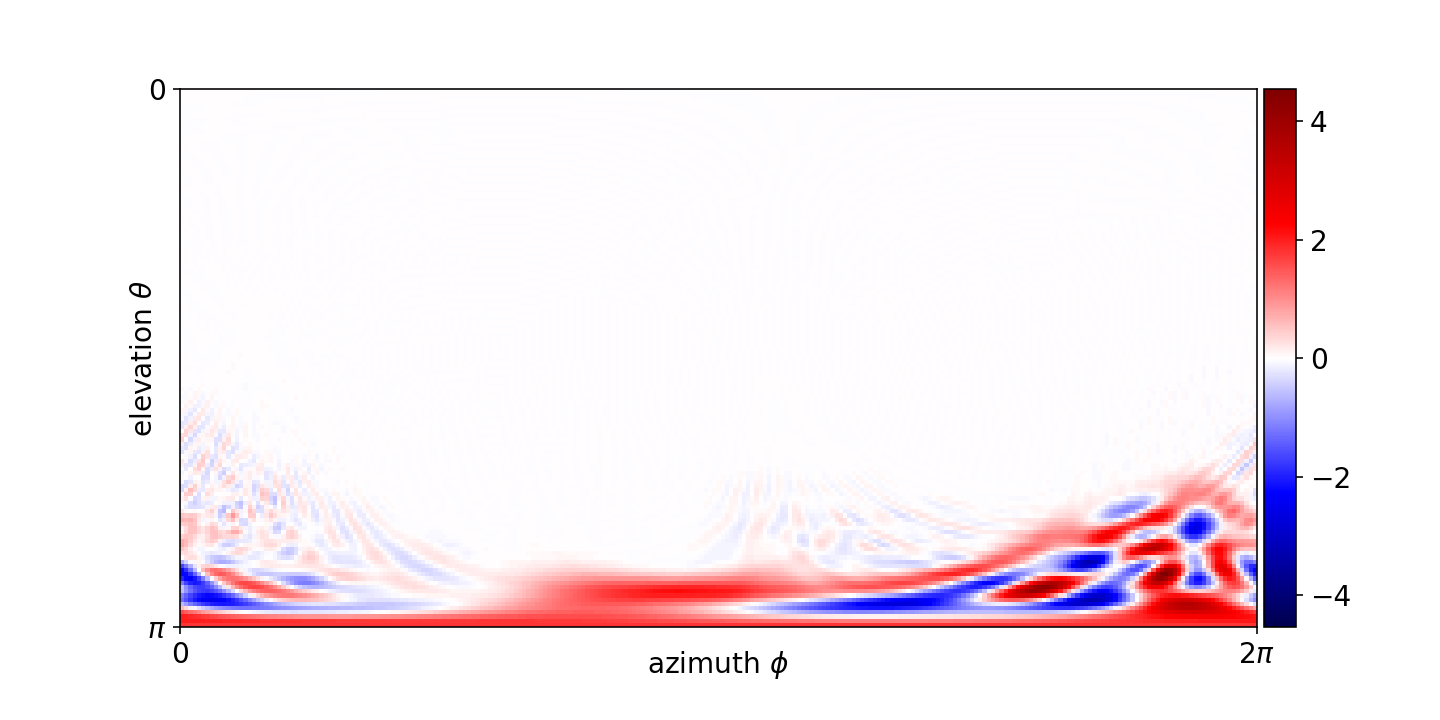

In [184]:
qf.plot(1j*np.outer(E[:,70],E[:,70].conj()))

In [182]:
np.linalg.eig?

In [183]:
lam[70]

(-2.289835760733906e-16+0.3871115000414225j)

In [ ]:
np.argmax(np.abs(E))